In [1]:
trial_number_ml = "009"
random_state_init = 999

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 19:01:23,083] A new study created in memory with name: no-name-659f8e1e-016d-4485-bfc3-5e494b48cb5a


[I 2024-05-01 19:02:34,126] Trial 0 finished with value: 0.8288147990125865 and parameters: {'n_estimators': 470, 'max_depth': 90, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8288147990125865.


[I 2024-05-01 19:02:56,264] Trial 1 finished with value: 0.8214823393167343 and parameters: {'n_estimators': 649, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8288147990125865.


[I 2024-05-01 19:03:18,198] Trial 5 finished with value: 0.8610098639766759 and parameters: {'n_estimators': 123, 'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.8610098639766759.


[I 2024-05-01 19:03:26,109] Trial 2 finished with value: 0.8269029551295726 and parameters: {'n_estimators': 840, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.8610098639766759.


[I 2024-05-01 19:03:50,227] Trial 3 finished with value: 0.841880758642408 and parameters: {'n_estimators': 935, 'max_depth': 39, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.8610098639766759.


[I 2024-05-01 19:04:10,017] Trial 4 pruned. 


[I 2024-05-01 19:04:26,921] Trial 6 finished with value: 0.8543173945285915 and parameters: {'n_estimators': 439, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.8610098639766759.


[I 2024-05-01 19:04:30,397] Trial 8 pruned. 


[I 2024-05-01 19:04:39,616] Trial 11 pruned. 


[I 2024-05-01 19:04:48,781] Trial 7 finished with value: 0.8693012931866434 and parameters: {'n_estimators': 541, 'max_depth': 72, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:04:57,015] Trial 13 pruned. 


[I 2024-05-01 19:04:57,901] Trial 12 pruned. 


[I 2024-05-01 19:05:15,054] Trial 14 finished with value: 0.8661109925943984 and parameters: {'n_estimators': 113, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:05:18,974] Trial 15 finished with value: 0.8600559737502413 and parameters: {'n_estimators': 146, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:05:26,722] Trial 17 pruned. 


[I 2024-05-01 19:05:31,502] Trial 16 finished with value: 0.8571831286380398 and parameters: {'n_estimators': 100, 'max_depth': 99, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:05:43,007] Trial 18 pruned. 


[I 2024-05-01 19:05:46,076] Trial 19 pruned. 


[I 2024-05-01 19:05:50,008] Trial 20 pruned. 


[I 2024-05-01 19:05:52,719] Trial 21 pruned. 


[I 2024-05-01 19:06:12,076] Trial 22 pruned. 


[I 2024-05-01 19:06:14,684] Trial 23 pruned. 


[I 2024-05-01 19:06:21,176] Trial 9 finished with value: 0.8546348500086349 and parameters: {'n_estimators': 852, 'max_depth': 69, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:06:35,072] Trial 24 finished with value: 0.8626052682371824 and parameters: {'n_estimators': 149, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:06:40,802] Trial 25 finished with value: 0.8622852731132987 and parameters: {'n_estimators': 174, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:06:48,462] Trial 10 finished with value: 0.8664309877182823 and parameters: {'n_estimators': 913, 'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:06:51,193] Trial 26 finished with value: 0.8651545627241235 and parameters: {'n_estimators': 191, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:06:58,513] Trial 29 pruned. 


[I 2024-05-01 19:07:01,590] Trial 30 pruned. 


[I 2024-05-01 19:07:08,891] Trial 27 finished with value: 0.8641996566401527 and parameters: {'n_estimators': 206, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:07:12,283] Trial 31 pruned. 


[I 2024-05-01 19:07:17,403] Trial 32 pruned. 


[I 2024-05-01 19:07:21,393] Trial 33 pruned. 


[I 2024-05-01 19:07:32,073] Trial 28 finished with value: 0.8654765895630797 and parameters: {'n_estimators': 347, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:07:39,313] Trial 36 pruned. 


[I 2024-05-01 19:07:47,637] Trial 37 pruned. 


[I 2024-05-01 19:07:56,555] Trial 39 pruned. 


[I 2024-05-01 19:08:13,130] Trial 38 pruned. 


[I 2024-05-01 19:08:19,174] Trial 40 pruned. 


[I 2024-05-01 19:08:23,254] Trial 34 finished with value: 0.8683438474588323 and parameters: {'n_estimators': 450, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:08:26,793] Trial 41 pruned. 


[I 2024-05-01 19:08:29,001] Trial 35 finished with value: 0.8683423236725283 and parameters: {'n_estimators': 429, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


[I 2024-05-01 19:08:31,637] Trial 42 pruned. 


[I 2024-05-01 19:08:39,016] Trial 44 pruned. 


[I 2024-05-01 19:08:41,049] Trial 45 pruned. 


[I 2024-05-01 19:08:48,431] Trial 46 pruned. 


[I 2024-05-01 19:08:51,938] Trial 43 pruned. 


[I 2024-05-01 19:09:03,252] Trial 49 pruned. 


[I 2024-05-01 19:09:03,404] Trial 48 pruned. 


[I 2024-05-01 19:09:11,923] Trial 47 finished with value: 0.8635622060362256 and parameters: {'n_estimators': 547, 'max_depth': 61, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8693012931866434.


Best trial for RandomForestClassifier:
  Value: 0.8693012931866434
  Params: 
    n_estimators: 541
    max_depth: 72
    min_samples_split: 17
    min_samples_leaf: 1
    max_features: log2

Best hyperparameters for RandomForestClassifier: {'n_estimators': 541, 'max_depth': 72, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}


[I 2024-05-01 19:09:16,120] A new study created in memory with name: no-name-8a7bd9b2-4cfa-4d8a-9c39-b4e068342b74


RandomForestClassifier accuracy: 0.8650



[I 2024-05-01 19:09:18,851] Trial 0 finished with value: 0.832636455063542 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.2510711373165682, 'min_child_weight': 10, 'subsample': 0.7618537020241481, 'colsample_bytree': 0.7979857711234575, 'gamma': 1.0116481086412805, 'reg_lambda': 0.8454868339190128, 'reg_alpha': 8.26588431117977}. Best is trial 0 with value: 0.832636455063542.


[I 2024-05-01 19:09:23,014] Trial 1 finished with value: 0.8635566188197767 and parameters: {'n_estimators': 353, 'max_depth': 8, 'learning_rate': 0.19464171177975773, 'min_child_weight': 4, 'subsample': 0.6450244418236863, 'colsample_bytree': 0.7524019621212178, 'gamma': 1.5769066919984653, 'reg_lambda': 0.10154097797212983, 'reg_alpha': 0.15397486975859573}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:24,503] Trial 4 finished with value: 0.854635865866171 and parameters: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.05635650612991618, 'min_child_weight': 10, 'subsample': 0.7520167104517016, 'colsample_bytree': 0.6184119526187772, 'gamma': 4.118884151145798, 'reg_lambda': 1.2012740429603663, 'reg_alpha': 0.015399127800171945}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:26,186] Trial 3 finished with value: 0.8434787025467548 and parameters: {'n_estimators': 835, 'max_depth': 10, 'learning_rate': 0.17532076969903074, 'min_child_weight': 9, 'subsample': 0.9678262021597901, 'colsample_bytree': 0.7427380542579096, 'gamma': 2.7181637313444535, 'reg_lambda': 2.5002243247425144, 'reg_alpha': 4.240708139053307}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:27,281] Trial 5 finished with value: 0.8304086794867889 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.10312492686317863, 'min_child_weight': 7, 'subsample': 0.6533168625085417, 'colsample_bytree': 0.5359594946293733, 'gamma': 1.8330234301162251, 'reg_lambda': 0.07335604296632921, 'reg_alpha': 9.382890751797975}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:27,538] Trial 2 finished with value: 0.8425182092463354 and parameters: {'n_estimators': 866, 'max_depth': 7, 'learning_rate': 0.1861605988924525, 'min_child_weight': 9, 'subsample': 0.5172660073909496, 'colsample_bytree': 0.7990657965272733, 'gamma': 3.957237896925206, 'reg_lambda': 0.3364719326839654, 'reg_alpha': 0.013152031782258199}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:27,827] Trial 7 pruned. 


[I 2024-05-01 19:09:28,645] Trial 6 finished with value: 0.8539968914759395 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.16541071709023664, 'min_child_weight': 9, 'subsample': 0.8412982757506595, 'colsample_bytree': 0.6569842884843256, 'gamma': 3.239368347266123, 'reg_lambda': 1.2055693211726617, 'reg_alpha': 0.04019544191859793}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:28,763] Trial 9 pruned. 


[I 2024-05-01 19:09:30,379] Trial 11 pruned. 


[I 2024-05-01 19:09:31,837] Trial 8 finished with value: 0.8603713975152125 and parameters: {'n_estimators': 120, 'max_depth': 10, 'learning_rate': 0.0803038955957784, 'min_child_weight': 6, 'subsample': 0.8232695713655815, 'colsample_bytree': 0.6516865981963054, 'gamma': 0.022968711374545814, 'reg_lambda': 0.26827193697679613, 'reg_alpha': 3.877605418836577}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:35,210] Trial 12 finished with value: 0.8594180152175459 and parameters: {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.29725317615631697, 'min_child_weight': 2, 'subsample': 0.7995216125036924, 'colsample_bytree': 0.7701344538574191, 'gamma': 2.9952337987043824, 'reg_lambda': 0.3627565834711297, 'reg_alpha': 0.8835240026937403}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:38,422] Trial 10 finished with value: 0.8575026158331557 and parameters: {'n_estimators': 572, 'max_depth': 10, 'learning_rate': 0.19961586114800509, 'min_child_weight': 7, 'subsample': 0.6749852246955632, 'colsample_bytree': 0.6169197011826281, 'gamma': 1.017271968329521, 'reg_lambda': 3.8684968278096465, 'reg_alpha': 0.11790396896244792}. Best is trial 1 with value: 0.8635566188197767.


[I 2024-05-01 19:09:39,757] Trial 16 pruned. 


[I 2024-05-01 19:09:40,741] Trial 13 finished with value: 0.868019788904804 and parameters: {'n_estimators': 469, 'max_depth': 5, 'learning_rate': 0.28795226067431573, 'min_child_weight': 2, 'subsample': 0.5379789735334493, 'colsample_bytree': 0.9388503990521303, 'gamma': 0.2366793647842902, 'reg_lambda': 0.016396708009235362, 'reg_alpha': 0.12638001018348474}. Best is trial 13 with value: 0.868019788904804.


[I 2024-05-01 19:09:41,381] Trial 15 finished with value: 0.8715305925497008 and parameters: {'n_estimators': 171, 'max_depth': 10, 'learning_rate': 0.0420844789211398, 'min_child_weight': 4, 'subsample': 0.8727221114403005, 'colsample_bytree': 0.6927047716925462, 'gamma': 0.16892774385086162, 'reg_lambda': 0.017921634340815302, 'reg_alpha': 0.13149282009636334}. Best is trial 15 with value: 0.8715305925497008.


[I 2024-05-01 19:09:41,961] Trial 18 pruned. 


[I 2024-05-01 19:09:45,802] Trial 19 finished with value: 0.8590954804498218 and parameters: {'n_estimators': 201, 'max_depth': 5, 'learning_rate': 0.23788910775033384, 'min_child_weight': 1, 'subsample': 0.5105135233358724, 'colsample_bytree': 0.9510673082373315, 'gamma': 0.6958539644462038, 'reg_lambda': 0.010240801114179833, 'reg_alpha': 0.056950937773194904}. Best is trial 15 with value: 0.8715305925497008.


[I 2024-05-01 19:09:46,508] Trial 14 finished with value: 0.8731219333800627 and parameters: {'n_estimators': 453, 'max_depth': 10, 'learning_rate': 0.01641543362058008, 'min_child_weight': 3, 'subsample': 0.8492752697683065, 'colsample_bytree': 0.6606230315987189, 'gamma': 0.023448631164440847, 'reg_lambda': 0.02522615937253319, 'reg_alpha': 0.1204455570995102}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:09:46,676] Trial 21 pruned. 


[I 2024-05-01 19:09:47,276] Trial 20 finished with value: 0.8622857810420665 and parameters: {'n_estimators': 183, 'max_depth': 6, 'learning_rate': 0.03434260167260103, 'min_child_weight': 3, 'subsample': 0.8997039352031743, 'colsample_bytree': 0.8701832360647345, 'gamma': 0.7444061108783329, 'reg_lambda': 0.03020796243880181, 'reg_alpha': 0.4034303870840472}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:09:48,052] Trial 22 pruned. 


[I 2024-05-01 19:09:49,785] Trial 17 finished with value: 0.8680213126911083 and parameters: {'n_estimators': 378, 'max_depth': 6, 'learning_rate': 0.07419451462791166, 'min_child_weight': 4, 'subsample': 0.5370343432970138, 'colsample_bytree': 0.8990928789483024, 'gamma': 0.044568127707721006, 'reg_lambda': 0.10049940166416335, 'reg_alpha': 2.140909294981487}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:09:52,318] Trial 23 finished with value: 0.8705731468218897 and parameters: {'n_estimators': 193, 'max_depth': 9, 'learning_rate': 0.05450105929631324, 'min_child_weight': 5, 'subsample': 0.910994515870438, 'colsample_bytree': 0.5782899222182611, 'gamma': 2.12188700309269, 'reg_lambda': 0.15742377881997624, 'reg_alpha': 0.29604524947930316}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:09:58,801] Trial 27 finished with value: 0.8705751785369621 and parameters: {'n_estimators': 224, 'max_depth': 10, 'learning_rate': 0.04716065060077477, 'min_child_weight': 5, 'subsample': 0.9972829098186791, 'colsample_bytree': 0.5673746877988877, 'gamma': 1.3075719779444797, 'reg_lambda': 0.1830844048988127, 'reg_alpha': 0.21226376500125996}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:10:00,327] Trial 28 pruned. 


[I 2024-05-01 19:10:00,797] Trial 26 finished with value: 0.8664259084306017 and parameters: {'n_estimators': 647, 'max_depth': 6, 'learning_rate': 0.060620158696733435, 'min_child_weight': 5, 'subsample': 0.7876525454411769, 'colsample_bytree': 0.7007146484416248, 'gamma': 1.1225406384931809, 'reg_lambda': 0.15084153007139087, 'reg_alpha': 1.7795479647255585}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:10:02,472] Trial 25 finished with value: 0.8677038572110647 and parameters: {'n_estimators': 615, 'max_depth': 6, 'learning_rate': 0.06692707428642973, 'min_child_weight': 5, 'subsample': 0.5829334355716866, 'colsample_bytree': 0.7035399240516668, 'gamma': 0.32045562491101165, 'reg_lambda': 0.15689331047575153, 'reg_alpha': 0.07002512097321947}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:10:05,312] Trial 29 finished with value: 0.8651525310090513 and parameters: {'n_estimators': 138, 'max_depth': 10, 'learning_rate': 0.08003525476515203, 'min_child_weight': 6, 'subsample': 0.8555890719088445, 'colsample_bytree': 0.6979227599655724, 'gamma': 0.46026396223797883, 'reg_lambda': 9.34278701062678, 'reg_alpha': 0.22396932606122158}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:10:05,893] Trial 24 finished with value: 0.8689777425613832 and parameters: {'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.05654056415480241, 'min_child_weight': 4, 'subsample': 0.5825620350863608, 'colsample_bytree': 0.6981158659475966, 'gamma': 0.029902597693937084, 'reg_lambda': 0.03647221808658034, 'reg_alpha': 0.07514409288661424}. Best is trial 14 with value: 0.8731219333800627.


[I 2024-05-01 19:10:06,609] Trial 33 pruned. 


[I 2024-05-01 19:10:08,206] Trial 31 finished with value: 0.873444976076555 and parameters: {'n_estimators': 232, 'max_depth': 10, 'learning_rate': 0.09124531280035672, 'min_child_weight': 3, 'subsample': 0.8500402651197175, 'colsample_bytree': 0.5694069546115922, 'gamma': 1.4007668686124966, 'reg_lambda': 0.0201118352807796, 'reg_alpha': 0.187965609733426}. Best is trial 31 with value: 0.873444976076555.


[I 2024-05-01 19:10:08,347] Trial 30 finished with value: 0.87599325470596 and parameters: {'n_estimators': 243, 'max_depth': 10, 'learning_rate': 0.09211167329394979, 'min_child_weight': 3, 'subsample': 0.8546518819643195, 'colsample_bytree': 0.5694671486629193, 'gamma': 0.4368478419721595, 'reg_lambda': 0.025994418275325625, 'reg_alpha': 0.223883700263203}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:09,376] Trial 34 pruned. 


[I 2024-05-01 19:10:11,232] Trial 32 finished with value: 0.8702597547719908 and parameters: {'n_estimators': 255, 'max_depth': 9, 'learning_rate': 0.09156140836754362, 'min_child_weight': 3, 'subsample': 0.9460152949512208, 'colsample_bytree': 0.5690562229566949, 'gamma': 1.3636941627008972, 'reg_lambda': 0.021813392351742716, 'reg_alpha': 0.027277937053281985}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:11,291] Trial 37 pruned. 


[I 2024-05-01 19:10:12,837] Trial 38 pruned. 


[I 2024-05-01 19:10:13,849] Trial 40 pruned. 


[I 2024-05-01 19:10:15,062] Trial 36 finished with value: 0.8724844827761356 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.09869255721475702, 'min_child_weight': 2, 'subsample': 0.7869881672409468, 'colsample_bytree': 0.6093980915584432, 'gamma': 0.6298819683068081, 'reg_lambda': 0.010085015869856311, 'reg_alpha': 0.1860894703346092}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:15,607] Trial 35 finished with value: 0.8734429443614828 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.03840916652091232, 'min_child_weight': 2, 'subsample': 0.7202690979778993, 'colsample_bytree': 0.593123449998949, 'gamma': 1.458843265674832, 'reg_lambda': 0.05769172903967125, 'reg_alpha': 0.21197850862217332}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:15,790] Trial 39 finished with value: 0.871530592549701 and parameters: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.1478156346730419, 'min_child_weight': 2, 'subsample': 0.7817434813548365, 'colsample_bytree': 0.5012328965459676, 'gamma': 0.8205105054872991, 'reg_lambda': 0.05781339687537162, 'reg_alpha': 0.7420016235233852}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:16,184] Trial 41 pruned. 


[I 2024-05-01 19:10:18,252] Trial 43 pruned. 


[I 2024-05-01 19:10:20,210] Trial 42 finished with value: 0.8712121212121213 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.11566994531991041, 'min_child_weight': 1, 'subsample': 0.8161686071965132, 'colsample_bytree': 0.5402206242388938, 'gamma': 1.6186044643079507, 'reg_lambda': 0.07614086357992264, 'reg_alpha': 0.5925795378895393}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:21,091] Trial 44 finished with value: 0.8686607950101077 and parameters: {'n_estimators': 264, 'max_depth': 9, 'learning_rate': 0.11527154669212278, 'min_child_weight': 1, 'subsample': 0.8171112688692069, 'colsample_bytree': 0.5426475026316954, 'gamma': 1.5521571784283172, 'reg_lambda': 0.08425391993798212, 'reg_alpha': 0.39277986305168056}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:22,071] Trial 45 finished with value: 0.8728014303274108 and parameters: {'n_estimators': 291, 'max_depth': 9, 'learning_rate': 0.08989976458096281, 'min_child_weight': 1, 'subsample': 0.842689565407421, 'colsample_bytree': 0.53869281567471, 'gamma': 2.0066271905507675, 'reg_lambda': 0.022425176473979014, 'reg_alpha': 0.3157271584846036}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:22,203] Trial 48 pruned. 


[I 2024-05-01 19:10:23,530] Trial 49 pruned. 


[I 2024-05-01 19:10:23,556] Trial 46 finished with value: 0.8728049858287873 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.08609608776189331, 'min_child_weight': 1, 'subsample': 0.7530154217891762, 'colsample_bytree': 0.6146698755595219, 'gamma': 1.9127632247315027, 'reg_lambda': 0.04568706375074281, 'reg_alpha': 0.3800855936689358}. Best is trial 30 with value: 0.87599325470596.


[I 2024-05-01 19:10:25,056] Trial 47 finished with value: 0.8689797742764556 and parameters: {'n_estimators': 206, 'max_depth': 9, 'learning_rate': 0.08772455894611061, 'min_child_weight': 2, 'subsample': 0.7542254613668333, 'colsample_bytree': 0.6017140742951896, 'gamma': 2.0068302325376566, 'reg_lambda': 0.022324427603881314, 'reg_alpha': 0.35120366566432654}. Best is trial 30 with value: 0.87599325470596.


Best trial for XGBClassifier:
  Value: 0.87599325470596
  Params: 
    n_estimators: 243
    max_depth: 10
    learning_rate: 0.09211167329394979
    min_child_weight: 3
    subsample: 0.8546518819643195
    colsample_bytree: 0.5694671486629193
    gamma: 0.4368478419721595
    reg_lambda: 0.025994418275325625
    reg_alpha: 0.223883700263203

Best hyperparameters for XGBClassifier: {'n_estimators': 243, 'max_depth': 10, 'learning_rate': 0.09211167329394979, 'min_child_weight': 3, 'subsample': 0.8546518819643195, 'colsample_bytree': 0.5694671486629193, 'gamma': 0.4368478419721595, 'reg_lambda': 0.025994418275325625, 'reg_alpha': 0.223883700263203}


[I 2024-05-01 19:10:26,109] A new study created in memory with name: no-name-f1dbf774-3c25-449d-8071-f1b3628f43f9


XGBClassifier accuracy: 0.8777



[I 2024-05-01 19:10:26,786] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 78, 'max_depth': 13, 'learning_rate': 0.4666828750486339, 'n_estimators': 729, 'min_child_weight': 0.018351387694204344, 'min_child_samples': 1603, 'subsample': 0.8392927112593785, 'colsample_bytree': 0.8705515736333683, 'reg_alpha': 0.007962400479226861, 'reg_lambda': 7.842767959425882e-07}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 19:10:26,834] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'max_depth': 11, 'learning_rate': 0.08084327494714445, 'n_estimators': 862, 'min_child_weight': 0.006686378553537535, 'min_child_samples': 1542, 'subsample': 0.8906210685080641, 'colsample_bytree': 0.8988936309698687, 'reg_alpha': 1.275334392045968e-06, 'reg_lambda': 2.912079495897719e-06}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 19:10:27,137] Trial 3 finished with value: 0.664332733977387 and parameters: {'boosting_type': 'goss', 'num_leaves': 36, 'max_depth': 0, 'learning_rate': 0.4797466498392179, 'n_estimators': 338, 'min_child_weight': 0.002174494678234308, 'min_child_samples': 1081, 'subsample': 0.9495491294909937, 'colsample_bytree': 0.9188080070685902, 'reg_alpha': 0.0002704139679118784, 'reg_lambda': 0.00034415284942988734}. Best is trial 3 with value: 0.664332733977387.


[I 2024-05-01 19:10:27,694] Trial 4 finished with value: 0.664332733977387 and parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.008642441332651931, 'n_estimators': 360, 'min_child_weight': 0.05974116181363356, 'min_child_samples': 1039, 'subsample': 0.8430708489058594, 'colsample_bytree': 0.9507832727693535, 'reg_alpha': 0.18638587983027857, 'reg_lambda': 0.05010959407723954}. Best is trial 3 with value: 0.664332733977387.


[I 2024-05-01 19:10:28,543] Trial 7 finished with value: 0.7440216783998211 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 15, 'learning_rate': 0.27363064154887184, 'n_estimators': 148, 'min_child_weight': 0.05239408261647988, 'min_child_samples': 634, 'subsample': 0.8070065690394254, 'colsample_bytree': 0.8781147553814214, 'reg_alpha': 3.111536099789094e-07, 'reg_lambda': 0.0005941034363853074}. Best is trial 7 with value: 0.7440216783998211.


[I 2024-05-01 19:10:28,636] Trial 8 pruned. 


[I 2024-05-01 19:10:29,387] Trial 6 finished with value: 0.6923831001940288 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 11, 'learning_rate': 0.11889289997919422, 'n_estimators': 912, 'min_child_weight': 0.0010717371539130302, 'min_child_samples': 751, 'subsample': 0.8654777336579317, 'colsample_bytree': 0.850842551002279, 'reg_alpha': 2.674495834109677e-06, 'reg_lambda': 1.3822297613930626e-06}. Best is trial 7 with value: 0.7440216783998211.


[I 2024-05-01 19:10:29,659] Trial 10 pruned. 


[I 2024-05-01 19:10:29,781] Trial 9 finished with value: 0.6786771503164397 and parameters: {'boosting_type': 'goss', 'num_leaves': 67, 'max_depth': 14, 'learning_rate': 0.20646345550970174, 'n_estimators': 391, 'min_child_weight': 0.008652546697625477, 'min_child_samples': 733, 'subsample': 0.8698614082418649, 'colsample_bytree': 0.8725558292843527, 'reg_alpha': 0.00022770809372226307, 'reg_lambda': 0.06377514574553964}. Best is trial 7 with value: 0.7440216783998211.


[I 2024-05-01 19:10:30,696] Trial 5 finished with value: 0.8549507817023742 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 5, 'learning_rate': 0.3147981663821335, 'n_estimators': 354, 'min_child_weight': 0.08317583845335415, 'min_child_samples': 61, 'subsample': 0.9906387810704869, 'colsample_bytree': 0.9699183539175512, 'reg_alpha': 1.1844874743092695e-05, 'reg_lambda': 0.005112169356073229}. Best is trial 5 with value: 0.8549507817023742.


[I 2024-05-01 19:10:34,938] Trial 13 finished with value: 0.8533599488007801 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.3457794409402775, 'n_estimators': 526, 'min_child_weight': 0.09161213655674008, 'min_child_samples': 62, 'subsample': 0.9975287688959147, 'colsample_bytree': 0.9949283699375587, 'reg_alpha': 1.2665036815601402e-10, 'reg_lambda': 0.0003080151093006426}. Best is trial 5 with value: 0.8549507817023742.


[I 2024-05-01 19:10:36,060] Trial 12 finished with value: 0.8294471703288331 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 6, 'learning_rate': 0.4312268137055696, 'n_estimators': 900, 'min_child_weight': 0.07075656617384787, 'min_child_samples': 274, 'subsample': 0.9097655673121103, 'colsample_bytree': 0.9212665939685947, 'reg_alpha': 6.937709957115664e-10, 'reg_lambda': 0.09478554237165902}. Best is trial 5 with value: 0.8549507817023742.


[I 2024-05-01 19:10:38,961] Trial 14 finished with value: 0.8559046719288087 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'max_depth': 4, 'learning_rate': 0.33920385321773144, 'n_estimators': 541, 'min_child_weight': 0.09135403064733409, 'min_child_samples': 103, 'subsample': 0.9947627324721484, 'colsample_bytree': 0.9914178270554416, 'reg_alpha': 1.4094786658861615e-10, 'reg_lambda': 0.0005485410564530468}. Best is trial 14 with value: 0.8559046719288087.


[I 2024-05-01 19:10:40,023] Trial 15 finished with value: 0.8591025914525747 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'max_depth': 4, 'learning_rate': 0.3450260942593769, 'n_estimators': 545, 'min_child_weight': 0.0969831797401794, 'min_child_samples': 129, 'subsample': 0.9982825574240205, 'colsample_bytree': 0.9994310731031116, 'reg_alpha': 2.9020345427724522e-08, 'reg_lambda': 0.00037644450628707214}. Best is trial 15 with value: 0.8591025914525747.


[I 2024-05-01 19:10:41,872] Trial 16 finished with value: 0.8259450014729934 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 0, 'learning_rate': 0.35163217250242035, 'n_estimators': 521, 'min_child_weight': 0.027605227717102884, 'min_child_samples': 334, 'subsample': 0.9965238273038936, 'colsample_bytree': 0.9923326149926813, 'reg_alpha': 4.421359139358818e-08, 'reg_lambda': 0.002196913537640579}. Best is trial 15 with value: 0.8591025914525747.


[I 2024-05-01 19:10:50,816] Trial 17 finished with value: 0.7998064791393655 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 0, 'learning_rate': 0.3808940332726185, 'n_estimators': 596, 'min_child_weight': 0.030570611950771404, 'min_child_samples': 426, 'subsample': 0.9620822652629272, 'colsample_bytree': 0.9867496461248081, 'reg_alpha': 2.30449034703327e-08, 'reg_lambda': 4.6805436272297934e-05}. Best is trial 15 with value: 0.8591025914525747.


[I 2024-05-01 19:10:51,004] Trial 19 pruned. 


[I 2024-05-01 19:10:51,195] Trial 20 pruned. 


[I 2024-05-01 19:10:52,675] Trial 11 finished with value: 0.8721660114385557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 14, 'learning_rate': 0.28512629526932803, 'n_estimators': 986, 'min_child_weight': 0.0052155964322256046, 'min_child_samples': 36, 'subsample': 0.8003799523669288, 'colsample_bytree': 0.9026728378496225, 'reg_alpha': 7.137743828610473e-09, 'reg_lambda': 3.1115088654164226e-08}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:10:52,883] Trial 18 finished with value: 0.8119215961153609 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 3, 'learning_rate': 0.3820836478957185, 'n_estimators': 667, 'min_child_weight': 0.02809387631935027, 'min_child_samples': 363, 'subsample': 0.9560518437270069, 'colsample_bytree': 0.9565735776961951, 'reg_alpha': 6.289532326018104e-09, 'reg_lambda': 5.98687259872791e-05}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:10:53,103] Trial 21 pruned. 


[I 2024-05-01 19:10:53,523] Trial 22 pruned. 


[I 2024-05-01 19:10:53,746] Trial 23 pruned. 


[I 2024-05-01 19:10:58,960] Trial 25 finished with value: 0.8520835238066213 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.31000775391199775, 'n_estimators': 806, 'min_child_weight': 0.01433315068051811, 'min_child_samples': 177, 'subsample': 0.981256564764737, 'colsample_bytree': 0.936248827477353, 'reg_alpha': 1.9499633094413485e-09, 'reg_lambda': 1.4798930085668313e-08}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:10:59,160] Trial 26 finished with value: 0.8492147421245644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.3062794826102107, 'n_estimators': 809, 'min_child_weight': 0.01383364491047927, 'min_child_samples': 162, 'subsample': 0.9779366523802893, 'colsample_bytree': 0.9772728896631407, 'reg_alpha': 1.1606328890346461e-09, 'reg_lambda': 0.0035272141020120003}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:10:59,426] Trial 0 finished with value: 0.8680243602637165 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 9, 'learning_rate': 0.4822303067767168, 'n_estimators': 801, 'min_child_weight': 0.001353869241748818, 'min_child_samples': 45, 'subsample': 0.997318589925233, 'colsample_bytree': 0.8673300985342692, 'reg_alpha': 1.1629370467746105e-08, 'reg_lambda': 0.001345223840106269}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:11:04,026] Trial 28 finished with value: 0.8441105659342334 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 7, 'learning_rate': 0.4293272640748928, 'n_estimators': 631, 'min_child_weight': 0.0021197657426349067, 'min_child_samples': 213, 'subsample': 0.9371407674036774, 'colsample_bytree': 0.9022959816268417, 'reg_alpha': 5.724842705640591e-09, 'reg_lambda': 2.337539737413482e-10}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:11:05,423] Trial 24 finished with value: 0.8629227237172259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.1864327514140699, 'n_estimators': 981, 'min_child_weight': 0.0037592628344376685, 'min_child_samples': 142, 'subsample': 0.9781332792828482, 'colsample_bytree': 0.9306796297243926, 'reg_alpha': 1.7273458841443158e-09, 'reg_lambda': 3.4965572679394544e-09}. Best is trial 11 with value: 0.8721660114385557.


[I 2024-05-01 19:11:07,364] Trial 30 pruned. 


[I 2024-05-01 19:11:09,194] Trial 27 finished with value: 0.8721700748687005 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 9, 'learning_rate': 0.26969082817479784, 'n_estimators': 440, 'min_child_weight': 0.0016887795940288982, 'min_child_samples': 25, 'subsample': 0.9698177670029118, 'colsample_bytree': 0.9793543001155793, 'reg_alpha': 3.566852138503035e-10, 'reg_lambda': 0.005069619188748155}. Best is trial 27 with value: 0.8721700748687005.


[I 2024-05-01 19:11:09,589] Trial 33 pruned. 


[I 2024-05-01 19:11:41,174] Trial 29 finished with value: 0.8779050985889739 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.43089710030847184, 'n_estimators': 650, 'min_child_weight': 0.0011249292234375144, 'min_child_samples': 20, 'subsample': 0.937990094322807, 'colsample_bytree': 0.8321129597566504, 'reg_alpha': 8.374371102123789e-07, 'reg_lambda': 1.5436996975265936e-07}. Best is trial 29 with value: 0.8779050985889739.


[I 2024-05-01 19:11:57,735] Trial 34 finished with value: 0.8712126291408893 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.23396765681587564, 'n_estimators': 991, 'min_child_weight': 0.005497537116333952, 'min_child_samples': 31, 'subsample': 0.9762250066755426, 'colsample_bytree': 0.905688668723195, 'reg_alpha': 5.064932837939597e-10, 'reg_lambda': 1.5095388946048246e-07}. Best is trial 29 with value: 0.8779050985889739.


[I 2024-05-01 19:12:00,733] Trial 32 finished with value: 0.8766312132386554 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'max_depth': 9, 'learning_rate': 0.12655964595897284, 'n_estimators': 995, 'min_child_weight': 0.0064325690573608756, 'min_child_samples': 22, 'subsample': 0.969204437880122, 'colsample_bytree': 0.8996645028503177, 'reg_alpha': 6.114433862433855e-05, 'reg_lambda': 1.5420350178990517e-07}. Best is trial 29 with value: 0.8779050985889739.


[I 2024-05-01 19:12:02,345] Trial 37 pruned. 


[I 2024-05-01 19:12:03,543] Trial 35 finished with value: 0.8686638425827162 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 12, 'learning_rate': 0.4974092816714807, 'n_estimators': 442, 'min_child_weight': 0.0015357797560774738, 'min_child_samples': 28, 'subsample': 0.936705882565399, 'colsample_bytree': 0.8538200150744976, 'reg_alpha': 7.253691186486271e-05, 'reg_lambda': 2.7238552056704316e-07}. Best is trial 29 with value: 0.8779050985889739.


[I 2024-05-01 19:12:04,435] Trial 39 pruned. 


[I 2024-05-01 19:12:07,693] Trial 40 pruned. 


[I 2024-05-01 19:12:10,623] Trial 41 pruned. 


[I 2024-05-01 19:12:10,827] Trial 42 pruned. 


[I 2024-05-01 19:12:11,378] Trial 43 pruned. 


[I 2024-05-01 19:12:15,711] Trial 38 finished with value: 0.8702592468432228 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.07901918896017833, 'n_estimators': 277, 'min_child_weight': 0.0065364677773798105, 'min_child_samples': 24, 'subsample': 0.9469675818595358, 'colsample_bytree': 0.8220399372791433, 'reg_alpha': 0.0032106782510239102, 'reg_lambda': 2.3980398961543832e-08}. Best is trial 29 with value: 0.8779050985889739.


[I 2024-05-01 19:12:16,638] Trial 31 finished with value: 0.8785435650504372 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.13413936636419302, 'n_estimators': 995, 'min_child_weight': 0.0010022234368765048, 'min_child_samples': 20, 'subsample': 0.8395482327719812, 'colsample_bytree': 0.8997397662067704, 'reg_alpha': 9.184256858721438e-07, 'reg_lambda': 1.1189590614888138e-07}. Best is trial 31 with value: 0.8785435650504372.


[I 2024-05-01 19:12:21,056] Trial 46 pruned. 


[I 2024-05-01 19:12:25,020] Trial 36 finished with value: 0.8775881510376985 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 13, 'learning_rate': 0.23624224301263427, 'n_estimators': 443, 'min_child_weight': 0.005739305283209828, 'min_child_samples': 23, 'subsample': 0.9386970248882539, 'colsample_bytree': 0.9073403163585482, 'reg_alpha': 5.952929916500887e-10, 'reg_lambda': 1.6704213576800703e-07}. Best is trial 31 with value: 0.8785435650504372.


[I 2024-05-01 19:12:26,296] Trial 48 pruned. 


[I 2024-05-01 19:12:28,636] Trial 49 pruned. 


[I 2024-05-01 19:12:53,236] Trial 47 finished with value: 0.8622873048283708 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 15, 'learning_rate': 0.23596993540384048, 'n_estimators': 942, 'min_child_weight': 0.002118263404698547, 'min_child_samples': 124, 'subsample': 0.8183083722017536, 'colsample_bytree': 0.885046608097879, 'reg_alpha': 5.2091291874551356e-05, 'reg_lambda': 1.068503630527451e-07}. Best is trial 31 with value: 0.8785435650504372.


[I 2024-05-01 19:13:02,403] Trial 44 finished with value: 0.873444468147787 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 10, 'learning_rate': 0.23190078198221212, 'n_estimators': 938, 'min_child_weight': 0.006078417147473072, 'min_child_samples': 22, 'subsample': 0.9747233774307634, 'colsample_bytree': 0.9107649399091905, 'reg_alpha': 2.9141274630121586e-05, 'reg_lambda': 2.7713770619282895e-07}. Best is trial 31 with value: 0.8785435650504372.


[I 2024-05-01 19:13:02,822] Trial 45 finished with value: 0.8657935371143551 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 10, 'learning_rate': 0.23858673189731422, 'n_estimators': 932, 'min_child_weight': 0.005631716260398448, 'min_child_samples': 26, 'subsample': 0.9724736242280017, 'colsample_bytree': 0.9085026211887597, 'reg_alpha': 2.768230668261797e-05, 'reg_lambda': 1.0407622318807226e-07}. Best is trial 31 with value: 0.8785435650504372.


Best trial for LGBMClassifier:
  Value: 0.8785435650504372
  Params: 
    boosting_type: dart
    num_leaves: 40
    max_depth: 13
    learning_rate: 0.13413936636419302
    n_estimators: 995
    min_child_weight: 0.0010022234368765048
    min_child_samples: 20
    subsample: 0.8395482327719812
    colsample_bytree: 0.8997397662067704
    reg_alpha: 9.184256858721438e-07
    reg_lambda: 1.1189590614888138e-07

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 13, 'learning_rate': 0.13413936636419302, 'n_estimators': 995, 'min_child_weight': 0.0010022234368765048, 'min_child_samples': 20, 'subsample': 0.8395482327719812, 'colsample_bytree': 0.8997397662067704, 'reg_alpha': 9.184256858721438e-07, 'reg_lambda': 1.1189590614888138e-07}


LGBMClassifier accuracy: 0.8764
LGBMClassifier accuracy: 0.8764



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_009/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

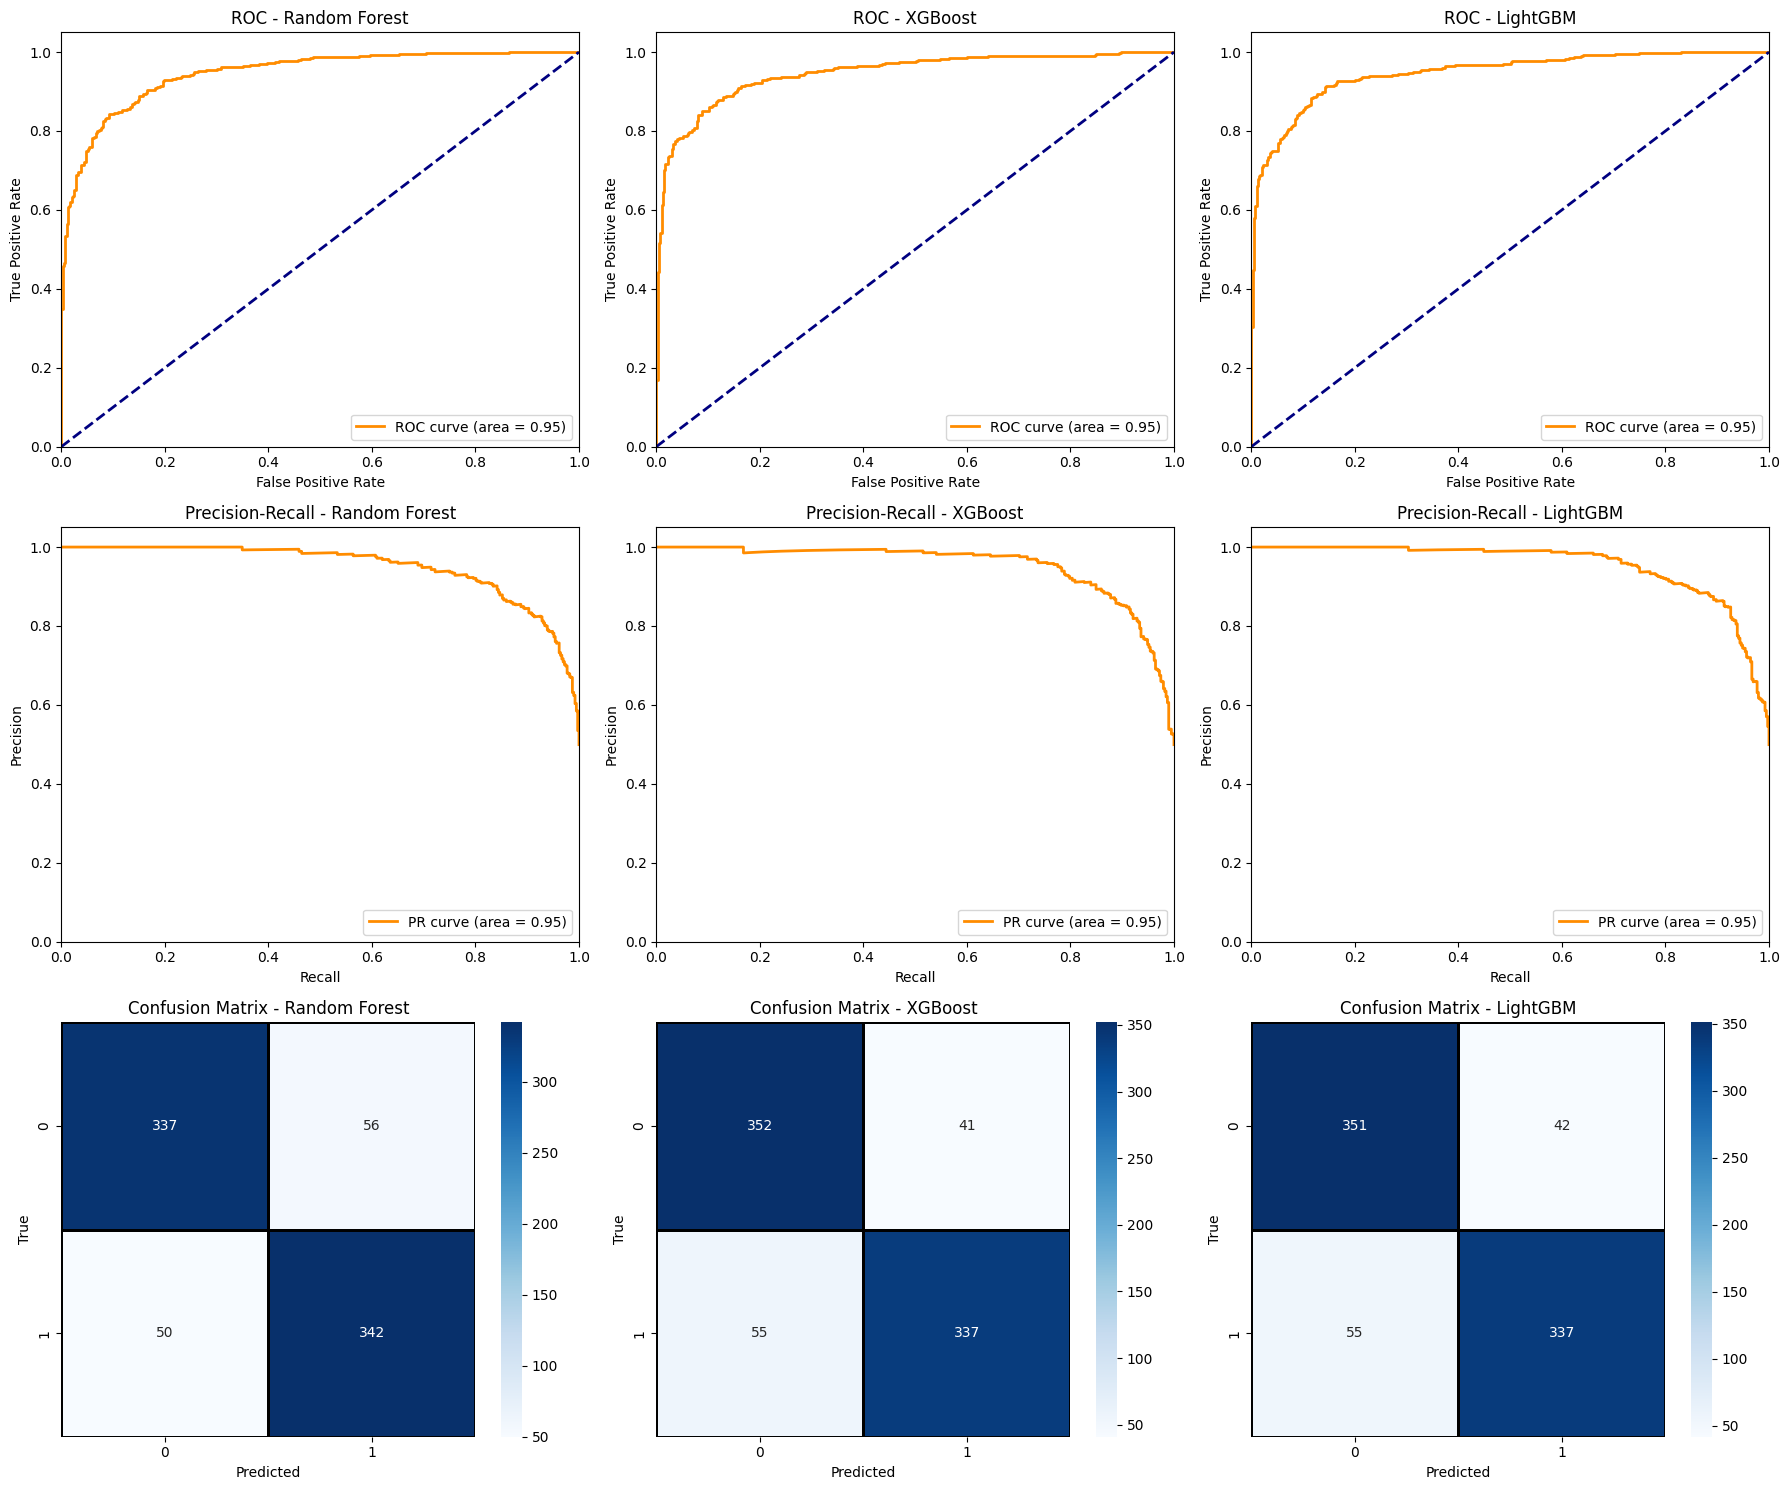

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8649681528662421, 'Precision': 0.8592964824120602, 'Recall': 0.8724489795918368, 'F1 Score': 0.8658227848101265, 'ROC AUC': 0.9456561250454381}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8777070063694268, 'Precision': 0.8915343915343915, 'Recall': 0.8596938775510204, 'F1 Score': 0.8753246753246754, 'ROC AUC': 0.9455912135846706}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8764331210191083, 'Precision': 0.8891820580474934, 'Recall': 0.8596938775510204, 'F1 Score': 0.874189364461738, 'ROC AUC': 0.9467726021706392}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8764331210191083,
 'Precision': 0.8891820580474934,
 'Recall': 0.8596938775510204,
 'F1 Score': 0.874189364461738,
 'ROC AUC': 0.9467726021706392}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: XGBoost with Accuracy: 0.8777


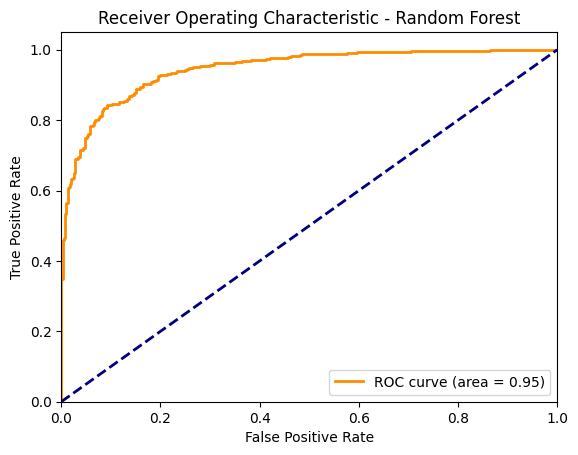

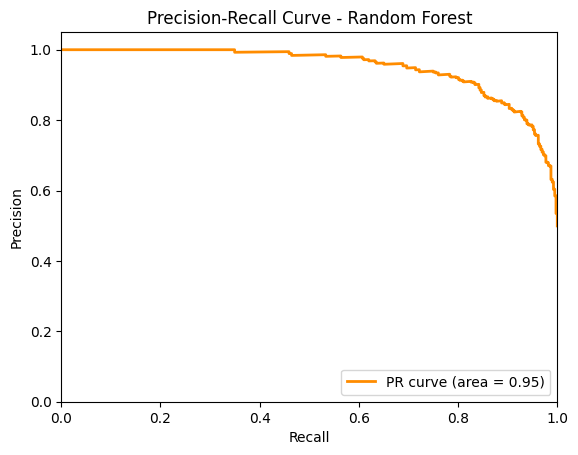

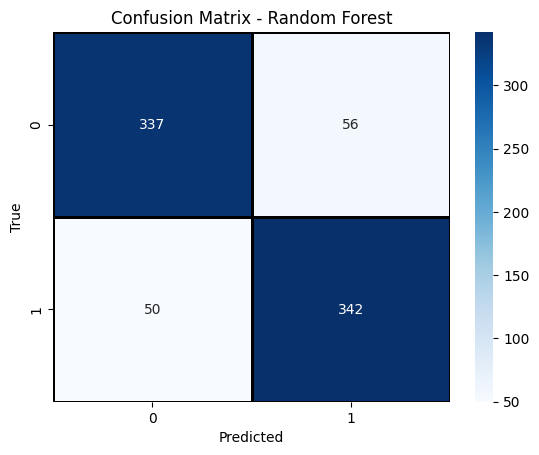

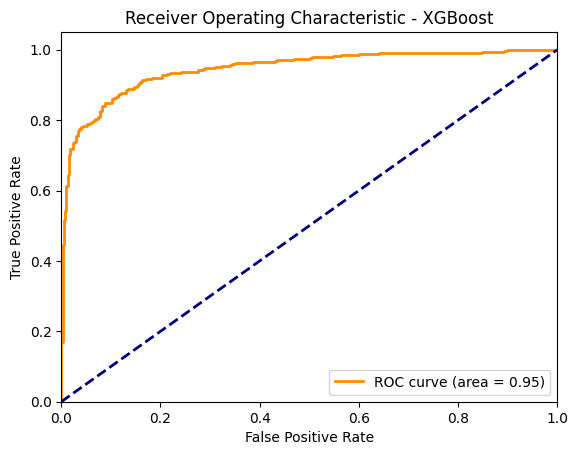

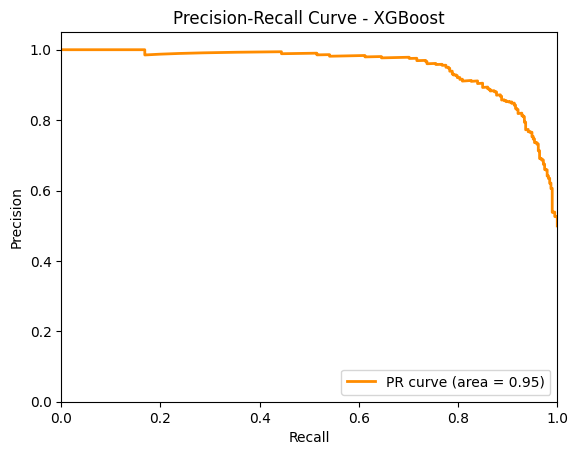

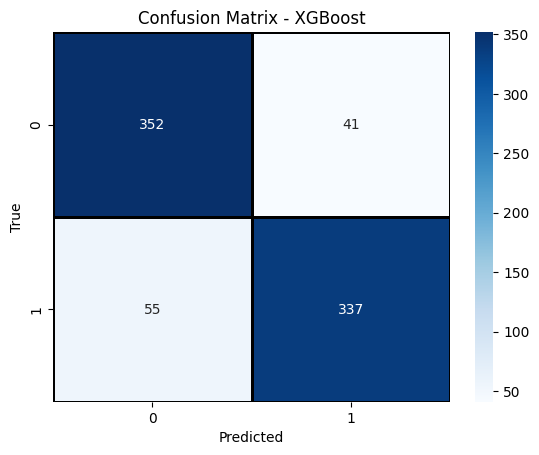

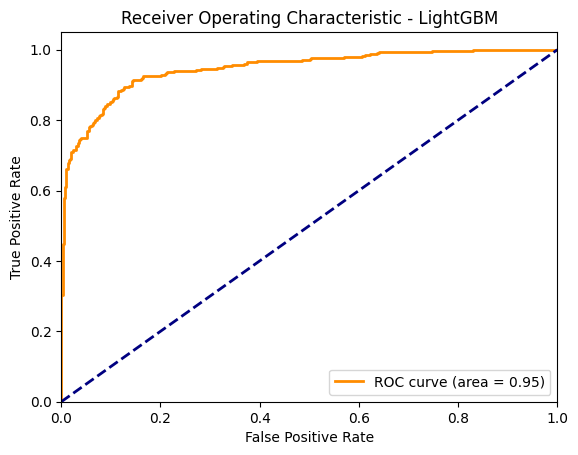

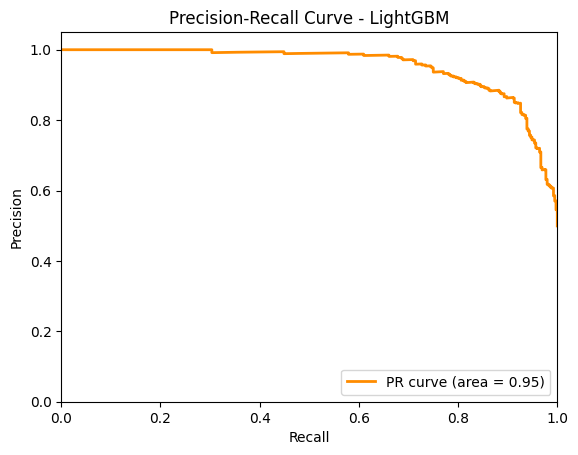

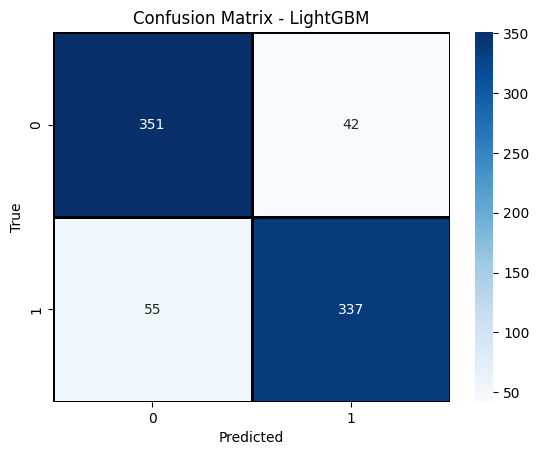

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

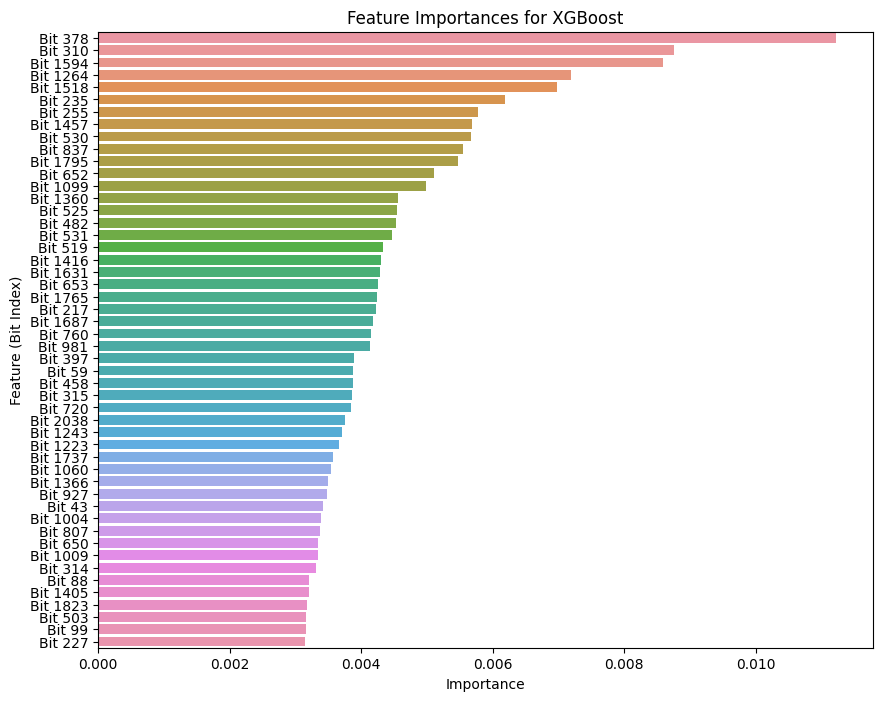

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
